In [20]:
import os, pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

In [3]:
with open('alexnet_acts.pkl', 'rb') as f:
    acts = pickle.load(f)
    
for layer, out in acts.items():
    print(f'{layer:<15} | {str(out.shape):>35}')

features.0      |      torch.Size([1072, 64, 55, 55])
features.1      |      torch.Size([1072, 64, 55, 55])
features.2      |      torch.Size([1072, 64, 27, 27])
features.3      |     torch.Size([1072, 192, 27, 27])
features.4      |     torch.Size([1072, 192, 27, 27])
features.5      |     torch.Size([1072, 192, 13, 13])
features.6      |     torch.Size([1072, 384, 13, 13])
features.7      |     torch.Size([1072, 384, 13, 13])
features.8      |     torch.Size([1072, 256, 13, 13])
features.9      |     torch.Size([1072, 256, 13, 13])
features.10     |     torch.Size([1072, 256, 13, 13])
features.11     |     torch.Size([1072, 256, 13, 13])
features.12     |       torch.Size([1072, 256, 6, 6])
features        |       torch.Size([1072, 256, 6, 6])
avgpool         |       torch.Size([1072, 256, 6, 6])
classifier.0    |            torch.Size([1072, 9216])
classifier.1    |            torch.Size([1072, 4096])
classifier.2    |            torch.Size([1072, 4096])
classifier.3    |           

=========== linear layer ==================
variance explained by first 50 pcs: 0.498
variance explained by first 2 pcs:  0.083

=========== relu layer ==================
variance explained by first 50 pcs: 0.498
variance explained by first 2 pcs:  0.083



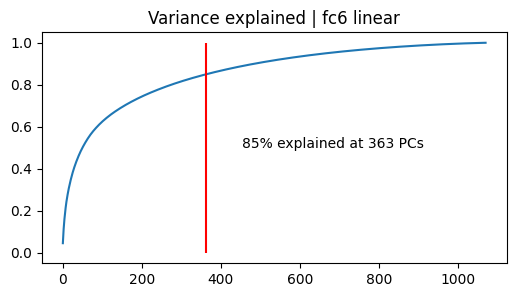

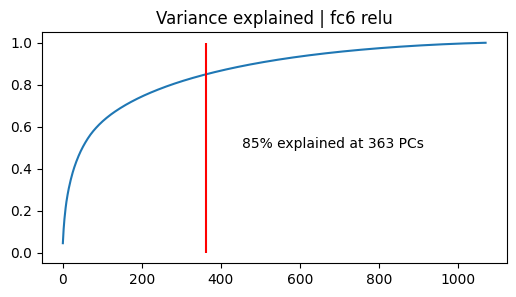

In [48]:
## PCA following Bao et al. 2020
## They get 85% variance at first 50 PCs...i need 363

# these are the exact same embeddings...
fc6 = {}
fc6['linear'] = acts['classifier.1'].detach().cpu().numpy()
fc6['relu'] = acts['classifier.2'].detach().cpu().numpy()

for layer, X in fc6.items():
    print(f'=========== {layer} layer ==================')
    # center across images (critical; sklearn does this internally, but be explicit)
    X = X - X.mean(axis=0, keepdims=True)
    n_img, n_units = X.shape

    # pca over images
    pca = PCA(n_components=min(n_img - 1, n_units), svd_solver='full')
    X_pca = pca.fit_transform(X)          # [n_img, n_img - 1]
    pcs = pca.components_                 # [n_img - 1, n_units]

    # retain first 50 pcs
    k = 50
    X_50 = X_pca[:, :k]                    # image coordinates in reduced space
    pcs_50 = pcs[:k]                       # [50, 4096]
    threshold = 0.85

    # variance explained
    var_explained = pca.explained_variance_ratio_
    var_50 = var_explained[:k].sum()
    var_2 = var_explained[:2].sum()
    cum_var = np.cumsum(var_explained)
    var_thresh = np.where(cum_var>threshold)[0][0]

    print(f'variance explained by first 50 pcs: {var_50:.3f}')
    print(f'variance explained by first 2 pcs:  {var_2:.3f}\n')
    
    fig, ax = plt.subplots(1,1, figsize=(6, 3))
    sns.lineplot(cum_var, ax=ax)
    ax.set_title(f'Variance explained | fc6 {layer}')
    ax.vlines(var_thresh, 0, 1, color='red')
    ax.text(x=var_thresh*1.25, y=0.5, s=f'{int(threshold*100)}% explained at {var_thresh} PCs')

pc1+pc2 variance (72-set): 0.293


Text(0.5, 1.0, 'All images in localizer space')

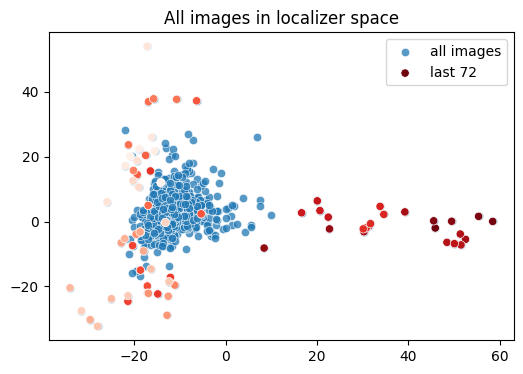

In [76]:
## MAYBE try just the localizer images?

# fc6: torch tensor [1072, 4096], post-relu
X = fc6['linear']

# z-score the data (based on all images)
mu = X.mean(axis=0, keepdims=True)          # per-unit mean
sd = X.std(axis=0, keepdims=True, ddof=1)   # per-unit std (unbiased)

Xz = (X - mu) / (sd + 1e-8)

# split 
X72 = Xz[1000:]          # basis-defining set
Xall = Xz              # everything to project

# fit pca on last 72 only
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X72)

# project all images into that space
Zall = pca.transform(Xall)    # [1072, 2]
Z72  = Zall[1000:]              # same points, highlighted

print(f'pc1+pc2 variance (72-set): {pca.explained_variance_ratio_.sum():.3f}')

# plot
fig,ax = plt.subplots(1,1, figsize=(6,4))

customp = sns.color_palette('Reds_r', len(Z72))

sns.scatterplot(x=Zall[:, 0], y=Zall[:, 1], alpha=0.75,  label='all images')
sns.scatterplot(x=Z72[:, 0], y=Z72[:, 1], color=customp, label='last 72')
ax.set_title('All images in localizer space')